In [1]:
import model
import data
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

To avoid verbose warning messages... 

In [2]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

Load MNIST dataset via a Dataset object:

In [3]:
dataset = data.Dataset(batch_size=128)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
55000


Training parameters:

In [4]:
learning_rate=0.001
num_steps = 5000
batch_size = 128

Model parameters:

In [5]:
temperature = 5000
dropout = 0.75

## Main Model Training

- ### Teacher Model

Output directory for model checkpoint:

In [8]:
checkpoint_dir="teachercpt_t3.5_test"
log_dir=checkpoint_dir + "\logs"

Model definition:

In [9]:
teacher_model = model.BigModel(num_steps=num_steps, 
                               batch_size=batch_size,
                               learning_rate=learning_rate,
                               temperature=temperature,
                               dropoutprob=dropout,
                               checkpoint_dir=checkpoint_dir,
                               log_dir=log_dir,
                               model_type="teacher");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [10]:
teacher_model.start_session()
teacher_model.train(dataset)

Starting Training
Model Checkpointed to teachercpt_t3.5_test\bigmodel.ckpt 
Step 1, Validation Loss= 76247.1328, Validation Accuracy= 0.060
Model Checkpointed to teachercpt_t3.5_test\bigmodel.ckpt 
Step 100, Validation Loss= 2212.1770, Validation Accuracy= 0.874
Model Checkpointed to teachercpt_t3.5_test\bigmodel.ckpt 
Optimization Finished!


Test the **teacher model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [11]:
# Load the best model from created checkpoint
teacher_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
teacher_model.run_inference(dataset)

Reading model parameters from teachercpt_t3.5_test\bigmodel.ckpt
Testing Accuracy: 0.876821


In [12]:
# Close current tf session
teacher_model.close_session()

- ### Simple Student Model
Simple, as in, trained with the same data and parameters as the teacher model. 

Output directory for model checkpoint:

In [6]:
checkpoint_dir="sstudentcpt_t1"
log_dir=checkpoint_dir + "\logs"

Model definition:

In [7]:
student_model = model.SmallModel(num_steps=num_steps, 
                                 batch_size=batch_size,
                                 learning_rate=learning_rate,
                                 temperature=temperature,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [8]:
student_model.start_session()
student_model.train(dataset)

Starting Training
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 1, Validation Loss= 14.2813, Validation Accuracy= 0.049
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 100, Validation Loss= 8.7166, Validation Accuracy= 0.150
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 200, Validation Loss= 5.8832, Validation Accuracy= 0.269
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 300, Validation Loss= 4.2642, Validation Accuracy= 0.387
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 400, Validation Loss= 3.2869, Validation Accuracy= 0.477
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 500, Validation Loss= 2.6678, Validation Accuracy= 0.550
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 600, Validation Loss= 2.2593, Validation Accuracy= 0.598
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 700, Validation Loss= 1.9642, Validation Accuracy= 0.641
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 800, Validation Loss= 1.7413, Validation 

Test the **student model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [9]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference(dataset)

Reading model parameters from sstudentcpt_t1\smallmodel
Testing Accuracy: 0.882048


In [10]:
# Close current tf session
student_model.close_session()

- ### Distilled Student Model
Training data consists of the **logits** from the Teacher Model predictions of the standard training set.

Pretrained **teacher model** loading:

In [ ]:
checkpoint_dir = "teachercpt_t1"
log_dir=checkpoint_dir + "\logs"

In [6]:
# Model definition
teacher_model = model.BigModel(num_steps=num_steps, 
                               batch_size=batch_size,
                               learning_rate=learning_rate,
                               temperature=temperature,
                               dropoutprob=dropout,
                               checkpoint_dir=checkpoint_dir,
                               log_dir=log_dir,
                               model_type="teacher");
# Start tf session
teacher_model.start_session()

In [7]:
# Load best model from teacher checkpoint
teacher_model.load_model_from_file(checkpoint_dir)

Reading model parameters from teachercpt_t1\bigmodel.ckpt


Verify **teacher** model state before training **student**:

In [8]:
# Test the model against the testing set
teacher_model.run_inference(dataset)

Testing Accuracy: 0.978365


Testing for a good temperature (one that better softens the probabilities):

In [10]:
test_images, test_labels = dataset.get_test_data()

In [13]:
res = teacher_model.predict(test_images[:10],9000)

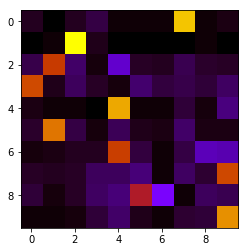

In [14]:
plt.imshow(res, cmap='gnuplot', interpolation='nearest')
plt.show()

Output directory for distilled student model checkpoint:

In [9]:
checkpoint_dir="dstudentcpt_t5000"
log_dir=checkpoint_dir + "\logs"

Student model definition:

In [10]:
student_model = model.SmallModel(num_steps=num_steps, 
                                 batch_size=batch_size,
                                 learning_rate=0.001,
                                 temperature=5000,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [11]:
student_model.start_session()
student_model.train(dataset, teacher_model)

Starting Training
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Step 1, Validation Loss= 3287.6296, Validation Accuracy= 0.102
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Step 100, Validation Loss= 685.4867, Validation Accuracy= 0.753
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Step 200, Validation Loss= 661.7147, Validation Accuracy= 0.836
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Step 300, Validation Loss= 637.1820, Validation Accuracy= 0.868
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Step 400, Validation Loss= 631.2465, Validation Accuracy= 0.885
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Step 500, Validation Loss= 635.9671, Validation Accuracy= 0.892
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Step 600, Validation Loss= 622.5181, Validation Accuracy= 0.897
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Step 700, Validation Loss= 598.4039, Validation Accuracy= 0.904
Model Checkpointed to dstudentcpt_t5000\smallmodel 
Ste

Test the **distilled student model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [12]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference(dataset)

Reading model parameters from dstudentcpt_t5000\smallmodel
Testing Accuracy: 0.918761


In [13]:
# Close current tf sessions
teacher_model.close_session()
student_model.close_session()

## Experiments

- ### 1. Learn from Probabilities
Take a class out from the training set for the Distilled Model, and later test the accuracy for that class. 

In [6]:
# MNIST dataset with class 3 excluded from training
dataset_ex = data.DatasetExclude(batch_size=128, exclude_class=[3])

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
55000


Pretrained **teacher model** loading:

In [7]:
checkpoint_dir = "teachercpt_t1"
log_dir=checkpoint_dir + "\logs"

In [8]:
# Model definition
teacher_model = model.BigModel(num_steps=num_steps, 
                               batch_size=batch_size,
                               learning_rate=learning_rate,
                               temperature=temperature,
                               dropoutprob=dropout,
                               checkpoint_dir=checkpoint_dir,
                               log_dir=log_dir,
                               model_type="teacher");
# Start tf session
teacher_model.start_session()

In [9]:
# Load best model from teacher checkpoint
teacher_model.load_model_from_file(checkpoint_dir)

Reading model parameters from teachercpt_t1\bigmodel.ckpt


Verify **teacher** model state before training **student**:

In [10]:
# Test the model against the testing set
teacher_model.run_inference(dataset)

Testing Accuracy: 0.978329


Output directory for distilled student model checkpoint:

In [11]:
checkpoint_dir="ex1_dstudentcpt_t8000_gd"
log_dir=checkpoint_dir + "\logs"

Student model definition:

In [12]:
student_model = model.SmallModel(num_steps=5000, 
                                 batch_size=batch_size,
                                 learning_rate=0.001,
                                 temperature=8000,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [13]:
student_model.start_session()

In [14]:
student_model.train(dataset_ex, teacher_model)

Starting Training
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 1, Validation Loss= 3657.5715, Validation Accuracy= 0.108
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 100, Validation Loss= 2197.6946, Validation Accuracy= 0.684
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 200, Validation Loss= 2170.9675, Validation Accuracy= 0.760
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 300, Validation Loss= 2080.8770, Validation Accuracy= 0.784
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 400, Validation Loss= 1974.6926, Validation Accuracy= 0.796
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 500, Validation Loss= 1905.7006, Validation Accuracy= 0.801
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 600, Validation Loss= 1834.5573, Validation Accuracy= 0.807
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 700, Validation Loss= 1797.7828, Validation Accuracy

Test the **distilled student model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [15]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference(dataset)

Reading model parameters from ex1_dstudentcpt_t8000_gd\smallmodel
Testing Accuracy: 0.834808


In [16]:
# Test the model againts a testing set containing only the initially excluded class
student_model.run_inference_ex(dataset_ex)

Testing Accuracy: 0.101980194


In [17]:
# Close current tf sessions
teacher_model.close_session()
student_model.close_session()

- ### 1.2 Learn from Probabilities (only 7s and 8s)
Take multiple classes out from the training set for the Distilled Model, and later test the accuracy for those classes. 

In [6]:
# MNIST dataset with class 3 excluded from training
dataset_ex = data.DatasetExclude(batch_size=128, exclude_class=[0,1,2,3,4,5,6,9])

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
55000


Pretrained **teacher model** loading:

In [7]:
checkpoint_dir = "teachercpt_t1"
log_dir=checkpoint_dir + "\logs"

In [8]:
# Model definition
teacher_model = model.BigModel(num_steps=num_steps, 
                               batch_size=batch_size,
                               learning_rate=learning_rate,
                               temperature=temperature,
                               dropoutprob=dropout,
                               checkpoint_dir=checkpoint_dir,
                               log_dir=log_dir,
                               model_type="teacher");
# Start tf session
teacher_model.start_session()

In [9]:
# Load best model from teacher checkpoint
teacher_model.load_model_from_file(checkpoint_dir)

Reading model parameters from teachercpt_t1\bigmodel.ckpt


Verify **teacher** model state before training **student**:

In [10]:
# Test the model against the testing set
teacher_model.run_inference(dataset)

Testing Accuracy: 0.978529


Output directory for distilled student model checkpoint:

In [11]:
checkpoint_dir="ex1.2_dstudentcpt_t8000"
log_dir=checkpoint_dir + "\logs"

Student model definition:

In [12]:
student_model = model.SmallModel(num_steps=5000, 
                                 batch_size=batch_size,
                                 learning_rate=0.001,
                                 temperature=8000,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [13]:
student_model.start_session()

In [14]:
student_model.train(dataset_ex, teacher_model)

Starting Training
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 1, Validation Loss= 3158.3208, Validation Accuracy= 0.072
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 100, Validation Loss= 12331.0996, Validation Accuracy= 0.197
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 200, Validation Loss= 9836.1826, Validation Accuracy= 0.202
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 300, Validation Loss= 8621.6064, Validation Accuracy= 0.217
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 400, Validation Loss= 7561.4312, Validation Accuracy= 0.238
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 500, Validation Loss= 7168.3433, Validation Accuracy= 0.255
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 600, Validation Loss= 6517.7607, Validation Accuracy= 0.286
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 700, Validation Loss= 6383.0327, Validation Accuracy= 0.297

Test the **distilled student model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [15]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference(dataset)

Reading model parameters from ex1.2_dstudentcpt_t8000\smallmodel
Testing Accuracy: 0.405558


In [16]:
# Test the model againts a testing set containing only the initially excluded class
student_model.run_inference_ex(dataset_ex)

Testing Accuracy: 0.17301923


In [17]:
# Close current tf sessions
teacher_model.close_session()
student_model.close_session()

- ### 2. Train distilled model with a transfer set

### Tests

In [12]:
only3Data = dataset_ex.get_test_data_ex()

In [13]:
test_images_ex, test_labels_ex = dataset_ex.get_test_data_ex()

In [14]:
res3 = student_model.predict(test_images_ex)
res3

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

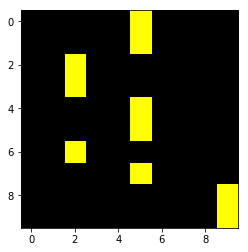

In [15]:
plt.imshow(res3[10:20], cmap='gnuplot', interpolation='nearest')
plt.show()

In [19]:
labels = [np.argmax(x) for x in res3];

In [22]:
len([x for x in labels if x != 3])

894

Softness

In [12]:
test_images, test_labels = dataset.get_test_data()

In [24]:
res = teacher_model.predict(test_images[:10],10000)
res

array([[0.02155227, 0.01782936, 0.01530081, 0.07333788, 0.01995625,
        0.75689876, 0.00749253, 0.01438484, 0.05224987, 0.02099747],
       [0.05230931, 0.53914374, 0.06466244, 0.02888518, 0.07134437,
        0.02954876, 0.03085313, 0.06112206, 0.10143644, 0.02069464],
       [0.03398941, 0.00770653, 0.02204861, 0.01915374, 0.02241081,
        0.05819929, 0.8147083 , 0.0022156 , 0.0103439 , 0.00922381],
       [0.03036679, 0.00649158, 0.02443155, 0.01460529, 0.77217335,
        0.00962574, 0.01572084, 0.05002068, 0.02894339, 0.0476208 ],
       [0.00897078, 0.00362565, 0.01240781, 0.00963021, 0.04857294,
        0.02797011, 0.863165  , 0.00986666, 0.01169004, 0.00410075],
       [0.05565168, 0.01574925, 0.02770146, 0.05238277, 0.07021851,
        0.04418492, 0.01563421, 0.10332207, 0.10259476, 0.51256037],
       [0.03368693, 0.02610323, 0.02370452, 0.09477874, 0.03724141,
        0.05075835, 0.01166267, 0.03371252, 0.6480025 , 0.04034916],
       [0.00738499, 0.00946992, 0.0157102

In [13]:
res = teacher_model.predict_logits(test_images[:3],5000)
res

array([[-1.0211494 , -0.5921386 , -1.7813059 , -0.22943072,  4.7421618 ,
        -0.46868637, -0.4402676 ,  1.3190312 , -0.25325492,  1.8988273 ],
       [ 0.70405686, -0.56497246,  2.7086508 ,  5.800044  ,  0.45443693,
         2.7497504 , -4.7013693 ,  0.15779269,  0.9306188 ,  2.5254018 ],
       [ 0.80967695,  4.779439  ,  0.55858225,  0.39275914, -0.4275604 ,
        -0.06877542, -0.65638787,  0.19440486,  0.2245654 , -0.8133921 ]],
      dtype=float32)

In [14]:
print(teacher_model.sess.run(tf.nn.softmax(res)))

[[2.7916129e-03 4.2871856e-03 1.3053397e-03 6.1616125e-03 8.8885218e-01
  4.8505040e-03 4.9903276e-03 2.8985638e-02 6.0165520e-03 5.1758908e-02]
 [5.3022010e-03 1.4904720e-03 3.9358661e-02 8.6619437e-01 4.1309278e-03
  4.1009989e-02 2.3818229e-05 3.0705535e-03 6.6504464e-03 3.2768480e-02]
 [1.7348994e-02 9.1900963e-01 1.3496629e-02 1.1434292e-02 5.0344146e-03
  7.2072139e-03 4.0047048e-03 9.3770269e-03 9.6641490e-03 3.4228223e-03]]


In [21]:
student_model.predict(test_images[:3],5000)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
test_labels[:3]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

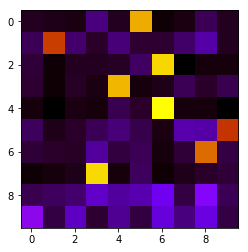

In [25]:
plt.imshow(res, cmap='gnuplot', interpolation='nearest')
plt.show()

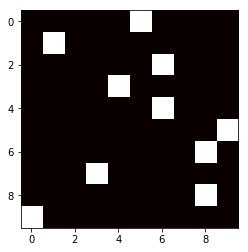

In [22]:
plt.imshow(test_labels[:10], cmap='hot', interpolation='nearest')
plt.show()